In [1]:
import wandb
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import numpy as np

In [2]:
loss_key = "train/elbo"

In [3]:
# fit to
# L = C + B / (t**b)

def loss_curve(steps, C, B, b):
    return C + B * steps**(-b)

def fit_loss_curve(history, x_key="_step", y_key="train/elbo", min_x=2000, max_x=None):

    h = history.copy()
    if min_x is not None:
        h = h.loc[h[x_key] >= min_x]
    if max_x is not None:
        h = h.loc[h[x_key] <= max_x]
    popt, pcov = curve_fit(loss_curve, h[x_key], h[y_key], p0=(0.0, 1.0, 1.0), maxfev=10000)

    r2 = 1 - (np.sum((h[y_key] - loss_curve(h[x_key], *popt)) ** 2) / np.sum((h[y_key] - np.mean(h[y_key])) ** 2))

    y_hat = loss_curve(history[x_key], *popt)

    return y_hat, popt, r2


In [4]:
runs = wandb.Api().runs(
    path="dvruette/EasyDeL-diffusiontrainer-Gidd",
    filters={
        "tags": "critical_bs",
        # "config.aux_lr": 1e-3,
        "config.lr": 0.1,
        "config.batch_size": 16,
    }
)

histories = [
    run.history(keys=["train/loss", "train/elbo", "train/visited_tokens"])
    for run in runs
]

len(runs)

7

(2000, np.float64(146158.28491040377))

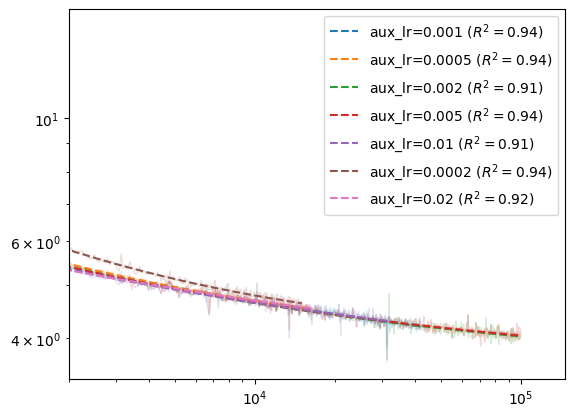

In [5]:
all_popts = []
lrs = [run.config.get("aux_lr") for run in runs]
for i, history in enumerate(histories):
    y_hat, popt, r2 = fit_loss_curve(history, y_key=loss_key, min_x=2000, max_x=None)
    all_popts.append(popt)

    plt.plot(history["_step"], history[loss_key], color=f"C{i}", linewidth=1.0, alpha=0.2)
    plt.plot(history["_step"], y_hat, label=f"aux_lr={lrs[i]} ($R^2={r2:.2f}$)", color=f"C{i}", linestyle="--")

    plt.legend()


plt.xscale("log")
plt.yscale("log")
plt.xlim(2000, None)
# plt.ylim(4, 5)

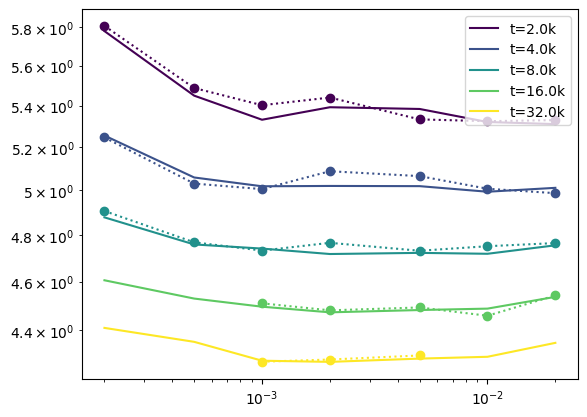

In [6]:
cmap = plt.get_cmap("viridis")

ts = np.logspace(np.log10(2000), np.log10(32000), 5)

# lrs = [run.config.get("lr") for run in runs]
lrs = [run.config.get("aux_lr") for run in runs]
for t in ts:
    ys = [loss_curve(t, *popt) for popt in all_popts]
    xs, ys = zip(*sorted(zip(lrs, ys)))
    color = cmap((np.log10(t) - np.log10(min(ts))) / (np.log10(max(ts)) - np.log10(min(ts))))

    plt.plot(xs, ys, label=f"t={t/1000:.1f}k", marker="none", color=color)

    y_true_ids = [history.loc[(history["_step"] - t).abs().sort_values().index[0], "_step"] for history in histories]
    y_true_smoothed = [history[loss_key].rolling(10, center=True).mean().loc[history["_step"] == idx] for idx, history in zip(y_true_ids, histories)]
    xs, y_true_smoothed = zip(*sorted(zip(lrs, y_true_smoothed)))
    plt.plot(xs, y_true_smoothed, marker="o", linestyle=":", color=color)

plt.xscale("log")
plt.yscale("log")
plt.legend(loc="upper right");


In [206]:
runs = wandb.Api().runs(
    path="dvruette/EasyDeL-diffusiontrainer-Gidd",
    order="config.batch_size",
    filters={
        "$and": [
            {"tags": "best_lr"},
            {"tags": "critical_bs"},
            {"tags": "tiny"},
            # {"tags": "small"},
        ],
    },
)

runs = sorted(runs, key=lambda run: run.config.get("batch_size"))

histories = [
    run.history(keys=["train/loss", "train/elbo", "train/visited_tokens"], samples=100000)
    for run in runs
]

len(runs)

7

In [207]:
popts = [fit_loss_curve(history, y_key=loss_key)[1] for history in histories]

min_loss = 3.5
max_loss = 5.6

/tmp/ipykernel_1418938/1790406006.py:12: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  fsolve(lambda x: loss_curve(x, *popt) - target_loss, 1.0)[0]


(2000, 100000)

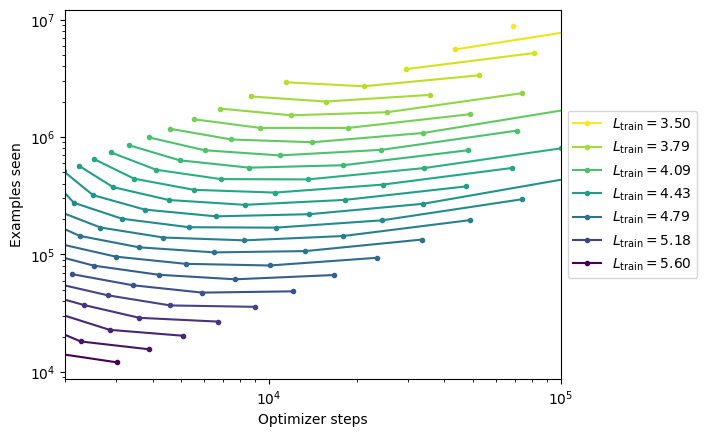

In [208]:
from scipy.optimize import fsolve


cmap = plt.get_cmap("viridis")

# min_loss = 0.67
# max_loss = 0.9

for i, target_loss in enumerate(np.logspace(np.log10(min_loss), np.log10(max_loss), 25)):
    # find x such that `loss_curve(x, *popt) = target_loss`
    steps = [
        fsolve(lambda x: loss_curve(x, *popt) - target_loss, 1.0)[0]
        for popt in popts
    ]


    color = cmap(1 - (target_loss - min_loss) / (max_loss - min_loss))

    batch_sizes = [run.config.get("batch_size") for run in runs]
    examples = [bs * t for bs, t, history in zip(batch_sizes, steps, histories) if t < 1.5*history["_step"].max() and t >= 1500]
    xs = [t for t, history in zip(steps, histories) if t < 1.5*history["_step"].max() and t >= 1500]
    # examples = [bs * t for bs, t, history in zip(batch_sizes, steps, histories)]
    # xs = [t for t, history in zip(steps, histories)]

    label = f"$L_\\text{{train}} = {target_loss:.2f}$" if i % 4 == 0 else None
    plt.plot(xs, examples, color=color, marker=".", linestyle="-", label=label)

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Optimizer steps")
plt.ylabel("Examples seen")
plt.legend(loc="center left", bbox_to_anchor=(1.0, 0.5));
plt.xlim(2000, 100000)

/tmp/ipykernel_1418938/3391250613.py:9: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  fsolve(lambda x: loss_curve(x, *popt) - target_loss, 1.0)[0]


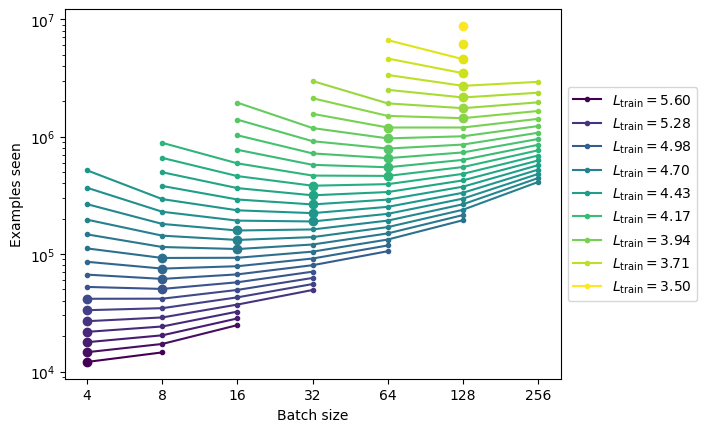

In [215]:
from scipy.optimize import fsolve

cmap = plt.get_cmap("viridis")

batch_sizes = [run.config.get("batch_size") for run in runs]
for i, target_loss in enumerate(np.logspace(np.log10(min_loss), np.log10(max_loss), 33)[::-1]):
    # find x such that `loss_curve(x, *popt) = target_loss`
    steps = [
        fsolve(lambda x: loss_curve(x, *popt) - target_loss, 1.0)[0]
        for popt in popts
    ]

    color = cmap(1 - (target_loss - min_loss) / (max_loss - min_loss))

    examples = [bs * t for bs, t, history in zip(batch_sizes, steps, histories) if t < 1.5*history["_step"].max() and t >= 1500]
    xs = [bs for t, bs, history in zip(steps, batch_sizes, histories) if t < 1.5*history["_step"].max() and t >= 1500]
    # examples = [bs * t for bs, t, history in zip(batch_sizes, steps, histories)]
    # xs = [t for t, history in zip(steps, histories)]

    label = f"$L_\\text{{train}} = {target_loss:.2f}$" if i % 4 == 0 else None
    plt.plot(xs, examples, color=color, marker=".", linestyle="-", label=label)

    optimal_x = xs[examples.index(min(examples))]
    plt.scatter([optimal_x], [min(examples)], color=color, marker="o", zorder=10)

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Batch size")
plt.xticks(batch_sizes, [f"{bs}" for bs in batch_sizes])
plt.xticks([], minor=True)
plt.ylabel("Examples seen")
plt.legend(loc="center left", bbox_to_anchor=(1.0, 0.5));
# plt.xlim(2000, 100000)

/tmp/ipykernel_1418938/2755624836.py:10: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  fsolve(lambda x: loss_curve(x, *popt) - target_loss, 1.0)[0]


(2000, 100000)

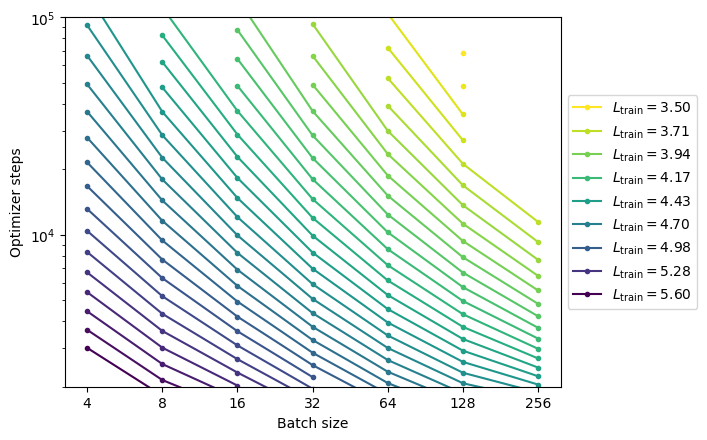

In [210]:
from scipy.optimize import fsolve

cmap = plt.get_cmap("viridis")

batch_sizes = [run.config.get("batch_size") for run in runs]

for i, target_loss in enumerate(np.logspace(np.log10(min_loss), np.log10(max_loss), 33)):
    # find x such that `loss_curve(x, *popt) = target_loss`
    steps = [
        fsolve(lambda x: loss_curve(x, *popt) - target_loss, 1.0)[0]
        for popt in popts
    ]


    color = cmap(1 - (target_loss - min_loss) / (max_loss - min_loss))

    points = [(bs, t) for bs, t, history in zip(batch_sizes, steps, histories) if t < 1.5*history["_step"].max() and t >= 1500]
    xs, ys = zip(*points) if points else ([], [])
    # examples = [bs * t for bs, t, history in zip(batch_sizes, steps, histories)]
    # xs = [t for t, history in zip(steps, histories)]

    label = f"$L_\\text{{train}} = {target_loss:.2f}$" if i % 4 == 0 else None
    plt.plot(xs, ys, color=color, marker=".", linestyle="-", label=label)

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Batch size")
plt.xticks(batch_sizes, [f"{bs}" for bs in batch_sizes])
plt.xticks([], minor=True)
plt.ylabel("Optimizer steps")
plt.legend(loc="center left", bbox_to_anchor=(1.0, 0.5));
plt.ylim(2000, 100000)

/tmp/ipykernel_1418938/3249192339.py:34: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(square_fn, np.log(xs), np.log10(examples), p0=(1, 1, 0))
/tmp/ipykernel_1418938/3249192339.py:12: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  fsolve(lambda x: loss_curve(x, *popt) - target_loss, 1.0)[0]


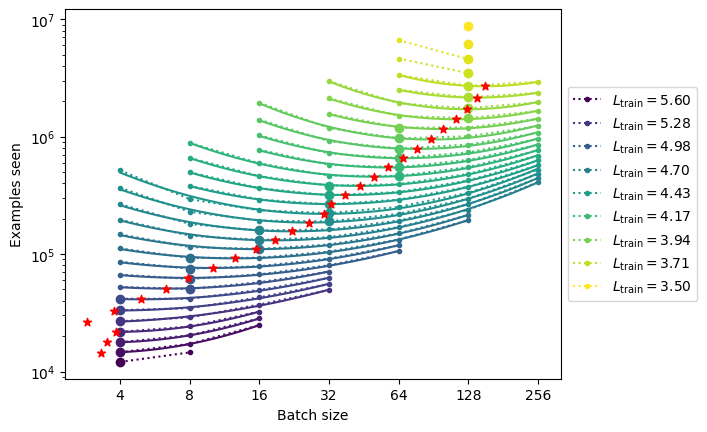

In [218]:
from scipy.optimize import fsolve

cmap = plt.get_cmap("viridis")

xs_star = []
ys_star = []

batch_sizes = [run.config.get("batch_size") for run in runs]
for i, target_loss in enumerate(np.logspace(np.log10(min_loss), np.log10(max_loss), 33)[::-1]):
    # find x such that `loss_curve(x, *popt) = target_loss`
    steps = [
        fsolve(lambda x: loss_curve(x, *popt) - target_loss, 1.0)[0]
        for popt in popts
    ]

    def square_fn(x, a, b, c):
        return a * (x-c)**2 + b

    color = cmap(1 - (target_loss - min_loss) / (max_loss - min_loss))

    examples = [bs * t for bs, t, history in zip(batch_sizes, steps, histories) if t < 1.5*history["_step"].max() and t >= 1500]
    xs = [bs for t, bs, history in zip(steps, batch_sizes, histories) if t < 1.5*history["_step"].max() and t >= 1500]
    # examples = [bs * t for bs, t, history in zip(batch_sizes, steps, histories)]
    # xs = [t for t, history in zip(steps, histories)]

    label = f"$L_\\text{{train}} = {target_loss:.2f}$" if i % 4 == 0 else None
    plt.plot(xs, examples, color=color, marker=".", linestyle=":", label=label)


    optimal_x = xs[examples.index(min(examples))]
    plt.scatter([optimal_x], [min(examples)], color=color, marker="o", zorder=10)

    if len(xs) > 2:
        popt, _ = curve_fit(square_fn, np.log(xs), np.log10(examples), p0=(1, 1, 0))

        # plot the fit
        x_fit = np.logspace(np.log10(min(xs)), np.log10(max(xs)), 100)
        y_fit = np.pow(10, square_fn(np.log(x_fit), *popt))
        plt.plot(x_fit, y_fit, color=color, linestyle="-")

        # plot the minimum
        idx = np.argmin(y_fit)
        x_star = np.exp(popt[-1])
        y_star = np.pow(10, square_fn(np.log(x_star), *popt))
        plt.scatter([x_star], [y_star], color="#ff0000", marker="*", zorder=10)

        xs_star.append(x_star)
        ys_star.append(y_star)

# # plot linear fit to log(xs_star) / log(ys_star)
# if len(xs_star) > 1:
#     popt, _ = curve_fit(lambda x, a, b: a * x + b, np.log(xs_star[-10:]), np.log(ys_star[-10:]))
#     x_fit = np.logspace(np.log10(16), np.log10(256), 100)
#     y_fit = np.exp(popt[1]) * x_fit ** popt[0]
#     plt.plot(x_fit, y_fit, color="#ff0000", linestyle="--")

# if len(xs_star) > 1:
#     popt, _ = curve_fit(lambda x, a, b: a * x + b, np.log(xs_star[:5]), np.log(ys_star[:5]))
#     x_fit = np.logspace(np.log10(min(xs_star)), np.log10(48), 100)
#     y_fit = np.exp(popt[1]) * x_fit ** popt[0]
#     plt.plot(x_fit, y_fit, color="#ff0000", linestyle="--")

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Batch size")
plt.xticks(batch_sizes, [f"{bs}" for bs in batch_sizes])
plt.xticks([], minor=True)
plt.ylabel("Examples seen")
plt.legend(loc="center left", bbox_to_anchor=(1.0, 0.5));
# plt.xlim(2000, 100000)